## Full Name: Mahdi Kafi
## Student Number: 99210753

# Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


# Loading Dataset

In [2]:
train_set = datasets.MNIST(root='./dataset', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_set, batch_size=100, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



# **VAE**

# Encoder 

In [25]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(1, 16, 5), nn.BatchNorm2d(16), nn.ReLU(),
            nn.Conv2d(16, 32, 5), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Flatten()
        )
        self.calc_mean = nn.Linear(12800, 256)
        self.calc_logvar = nn.Linear(12800, 256)

    def forward(self, x):
        x = self.encode(x)
        mean = self.calc_mean(x)
        logvar = self.calc_logvar(x)
        return mean, logvar

# Decoder

In [26]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decode_fc = nn.Sequential(
            nn.Linear(256, 12800), nn.BatchNorm1d(12800), nn.ReLU()
        )
        self.decode_convtrans = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 5), nn.BatchNorm2d(16), nn.ReLU(), 
            nn.ConvTranspose2d(16, 1, 5), nn.Sigmoid()
        )
    def forward(self, z):
        out = self.decode_fc(z)
        out = out.view(-1, 32, 20, 20)
        out = self.decode_convtrans(out)
        return out

# VAE

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device.")

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)

    def reparameterize(self, mean, logvar):
        eps = torch.randn_like(logvar).to(device)
        sigma = 0.5 * torch.exp(logvar)
        return mean + eps * sigma

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        # print(z.size())
        return self.decoder(z), mean, logvar

    def generate(self):
        z = torch.randn((1, 256)).to(device)
        # print(z.size())
        return self.decoder(z).squeeze(0)

model = VAE().to(device)

Using cuda device.


# Loss Function

In [28]:
BCE_loss = nn.BCELoss(reduction='sum')
def loss_fn(x, x_hat, mean, logvar):
    reconstruction_loss = BCE_loss(x_hat, x)
    KLD = 0.5 * torch.sum(-1 - logvar + torch.exp(logvar) + mean**2)
    return reconstruction_loss + KLD

# Train VAE

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 200
dataset_size = len(train_loader.dataset)
for epoch in range(num_epochs):
    epoch_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        imgs_hat, mean, logvar = model(imgs)
        loss = loss_fn(imgs, imgs_hat, mean, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.cpu().item()
    epoch_loss /= dataset_size
    print(f"Epoch {epoch+1}\nLoss: {epoch_loss:.5f}\n{'-'*30}")


Epoch 1
Loss: 160.22804
------------------------------
Epoch 2
Loss: 97.51267
------------------------------
Epoch 3
Loss: 90.67088
------------------------------
Epoch 4
Loss: 86.67885
------------------------------
Epoch 5
Loss: 84.23999
------------------------------
Epoch 6
Loss: 82.75004
------------------------------
Epoch 7
Loss: 81.90334
------------------------------
Epoch 8
Loss: 81.27004
------------------------------
Epoch 9
Loss: 80.87815
------------------------------
Epoch 10
Loss: 80.46024
------------------------------
Epoch 11
Loss: 80.15787
------------------------------
Epoch 12
Loss: 79.91797
------------------------------
Epoch 13
Loss: 79.69125
------------------------------
Epoch 14
Loss: 79.46624
------------------------------
Epoch 15
Loss: 79.31841
------------------------------
Epoch 16
Loss: 79.10208
------------------------------
Epoch 17
Loss: 78.96624
------------------------------
Epoch 18
Loss: 78.80118
------------------------------
Epoch 19
Loss: 78.

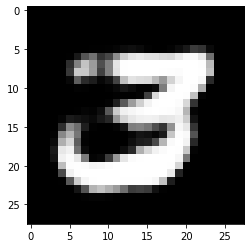

In [111]:
model.eval()
with torch.no_grad():
    generated_img = model.generate().squeeze(0)
plt.imshow(generated_img.cpu().detach().numpy(), cmap='gray')

# **CVAE**

# Encoder

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256), nn.BatchNorm1d(256), nn.ReLU(),
            nn.Linear(256, 64), nn.BatchNorm1d(64), nn.ReLU(),
        )
        self.calc_mean = nn.Linear(64+16, 16)
        self.calc_logvar = nn.Linear(64+16, 16)

    def forward(self, x, y):
        x = self.encode(x)
        x = torch.cat((x, y), dim=1)
        mean = self.calc_mean(x)
        logvar = self.calc_logvar(x)
        return mean, logvar

# Decoder

In [4]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decode = nn.Sequential(
            nn.Linear(32, 128), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, 256), nn.BatchNorm1d(256), nn.ReLU(),
            nn.Linear(256, 784), nn.BatchNorm1d(784), nn.Sigmoid()
        )

    def forward(self, z, y):
        return self.decode(torch.cat((z, y), dim=1)).view(-1, 1, 28, 28)

# CVAE

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device.")

class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        self.encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)
        self.label_embedding = nn.Embedding(10, 16)

    def reparameterize(self, mean, logvar):
        eps = torch.randn_like(logvar).to(device)
        sigma = 0.5 * torch.exp(logvar)
        return mean + eps * sigma

    def forward(self, x, y):
        y = self.label_embedding(y)
        # print(y.size())
        # print(x.size())
        mean, logvar = self.encoder(x, y)
        z = self.reparameterize(mean, logvar)
        # print(z.size())
        return self.decoder(z, y), mean, logvar

    def generate(self, class_idx):
        class_idx = torch.tensor(class_idx).to(device)
        # print(class_idx.size())
        class_idx = class_idx.unsqueeze(0)
        # print(class_idx, class_idx.size())
        y = self.label_embedding(class_idx)
        # print(y.size())
        z = torch.randn((1, 16)).to(device)
        return self.decoder(z, y).squeeze(0)

model = CVAE().to(device)

Using cuda device.


# Loss Function

In [10]:
BCE_loss = nn.BCELoss(reduction='sum')
def loss_fn(x, x_hat, mean, logvar):
    reconstruction_loss = BCE_loss(x_hat, x)
    KLD = 0.5 * torch.sum(-1 - logvar + torch.exp(logvar) + mean**2)
    return reconstruction_loss + KLD

# Train CVAE

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 200
dataset_size = len(train_loader.dataset)
for epoch in range(num_epochs):
    epoch_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        imgs_hat, mean, logvar = model(imgs, labels)
        loss = loss_fn(imgs, imgs_hat, mean, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.cpu().item()
    epoch_loss /= dataset_size
    print(f"Epoch {epoch+1}\nLoss: {epoch_loss:.5f}\n{'-'*30}")


Epoch 1
Loss: 215.85463
------------------------------
Epoch 2
Loss: 167.66456
------------------------------
Epoch 3
Loss: 141.05971
------------------------------
Epoch 4
Loss: 124.83353
------------------------------
Epoch 5
Loss: 114.40417
------------------------------
Epoch 6
Loss: 107.27652
------------------------------
Epoch 7
Loss: 102.28167
------------------------------
Epoch 8
Loss: 98.64553
------------------------------
Epoch 9
Loss: 95.85272
------------------------------
Epoch 10
Loss: 93.69705
------------------------------
Epoch 11
Loss: 92.14314
------------------------------
Epoch 12
Loss: 90.98652
------------------------------
Epoch 13
Loss: 89.95194
------------------------------
Epoch 14
Loss: 89.10646
------------------------------
Epoch 15
Loss: 88.52146
------------------------------
Epoch 16
Loss: 87.94161
------------------------------
Epoch 17
Loss: 87.45055
------------------------------
Epoch 18
Loss: 87.07983
------------------------------
Epoch 19
Los

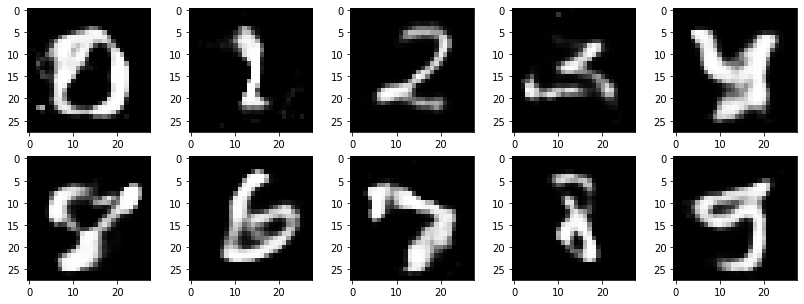

In [21]:
fig, ax = plt.subplots(2, 5, figsize=(14, 5))
model.eval()
with torch.no_grad():
    for class_idx in range(10):
        img = model.generate(class_idx).cpu().detach().numpy()
        ax[class_idx//5, class_idx%5].imshow(img.squeeze(), cmap='gray')